In [3]:
import pandas as pd

df = pd.read_csv('MSFT.csv')
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060163,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062311,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063386,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061774,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060700,47894400


In [5]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

datetime_object = str_to_datetime('1986-03-19')
datetime_object

datetime.datetime(1986, 3, 19, 0, 0)

In [6]:
df['Date'] = df['Date'].apply(str_to_datetime)
df['Date']

0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9600   2024-04-17
9601   2024-04-18
9602   2024-04-19
9603   2024-04-22
9604   2024-04-23
Name: Date, Length: 9605, dtype: datetime64[ns]

In [7]:
df.index = df.pop('Date')
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060163,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062311,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063386,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.061774,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060700,47894400
...,...,...,...,...,...,...
2024-04-17,417.250000,418.880005,410.329987,411.839996,411.839996,15855500
2024-04-18,410.630005,411.890015,403.950012,404.269989,404.269989,21029900
2024-04-19,404.029999,405.480011,397.769989,399.119995,399.119995,30276500


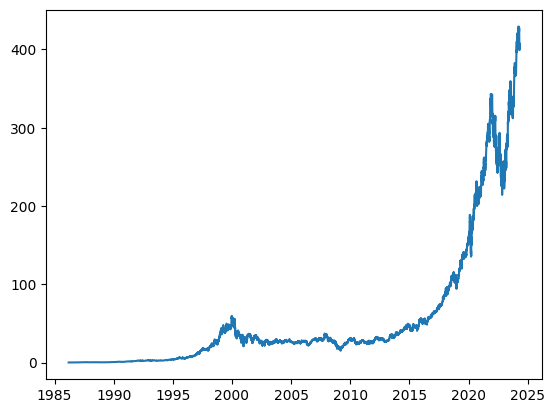

In [8]:
import matplotlib.pyplot as plt

plt.plot(df.index, df['Close'])

In [11]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df,
                                '1990-03-25',
                                '2024-04-23',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,1990-03-25,0.784722,0.786458,0.772569,0.765625
1,1990-03-27,0.772569,0.765625,0.774306,0.781250
2,1990-03-28,0.765625,0.774306,0.781250,0.770833
3,1990-03-29,0.774306,0.781250,0.770833,0.767361
4,1990-03-30,0.781250,0.770833,0.767361,0.769097
...,...,...,...,...,...
8580,2024-04-17,421.899994,413.640015,414.579987,411.839996
8581,2024-04-18,413.640015,414.579987,411.839996,404.269989
8582,2024-04-19,414.579987,411.839996,404.269989,399.119995
8583,2024-04-22,411.839996,404.269989,399.119995,400.959991


In [13]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((8585,), (8585, 3, 1), (8585,))

In [14]:
# prompt: implement k cross fold validation

from sklearn.model_selection import KFold

n_splits = 5

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for train_index, test_index in kf.split(dates):
  print("TRAIN:", train_index, "TEST:", test_index)
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]


TRAIN: [   0    1    2 ... 8581 8582 8584] TEST: [   8   14   17 ... 8562 8574 8583]
TRAIN: [   1    2    3 ... 8582 8583 8584] TEST: [   0   15   29 ... 8568 8578 8579]
TRAIN: [   0    1    2 ... 8580 8582 8583] TEST: [   6   12   18 ... 8577 8581 8584]
TRAIN: [   0    3    4 ... 8581 8583 8584] TEST: [   1    2    7 ... 8573 8580 8582]
TRAIN: [   0    1    2 ... 8582 8583 8584] TEST: [   3    4    5 ... 8567 8570 8572]


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])


model.fit(X_train, y_train, epochs=100, batch_size=32)
model.evaluate(X_test, y_test)


Epoch 1/100
215/215 [==============================] - 4s 5ms/step - loss: 6101.0229 - accuracy: 1.4560e-04
Epoch 2/100
215/215 [==============================] - 1s 5ms/step - loss: 40.4320 - accuracy: 4.3681e-04
Epoch 3/100
215/215 [==============================] - 1s 4ms/step - loss: 19.1599 - accuracy: 4.3681e-04
Epoch 4/100
215/215 [==============================] - 1s 4ms/step - loss: 12.3544 - accuracy: 4.3681e-04
Epoch 5/100
215/215 [==============================] - 1s 4ms/step - loss: 7.0992 - accuracy: 4.3681e-04
Epoch 6/100
215/215 [==============================] - 1s 5ms/step - loss: 7.2241 - accuracy: 4.3681e-04
Epoch 7/100
215/215 [==============================] - 1s 5ms/step - loss: 9.8422 - accuracy: 4.3681e-04
Epoch 8/100
215/215 [==============================] - 1s 6ms/step - loss: 7.0407 - accuracy: 4.3681e-04
Epoch 9/100
215/215 [==============================] - 1s 6ms/step - loss: 8.5879 - accuracy: 4.3681e-04
Epoch 10/100
215/215 [===========================

[10.459197044372559, 0.0]